# Proyecto 1 - Etapa 1

In [77]:
import pandas as pd
import nltk

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import tree
import sklearn as sklearn
from joblib import dump, load
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [78]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('stopwords-es')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\Mariana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mariana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading stopwords-es: Package 'stopwords-es' not
[nltk_data]     found in index
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mariana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mariana/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 1. Carga de datos

In [79]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
news=pd.read_csv("./fake_news.csv", sep=";")
data= news.copy()

In [80]:
data.shape

(57063, 5)

In [81]:
data.sample(5)

ID  Label                                             Titulo  \
42292  ID      1  La televisi√≥n gallega increpa a dos concursant...   
48722  ID      1  La Polic√≠a Local de Palma mont√≥ una unidad par...   
16785  ID      1  Las encuestas mantienen a Feij√≥o atado a Vox p...   
12090  ID      0  El Gobierno afirma que la ilegalizaci√≥n de la ...   
13943  ID      0  M√≥nica Garc√≠a:'Es vergonzoso regalar un Tois√≥n...   

                                             Descripcion       Fecha  
42292  Sara Marchena y Aurora Redondo participaron en...  26/10/2020  
48722  La mafia policial mallorquina destapada con el...  23/06/2019  
16785  El estudio de enero de Key Data para P√∫blico s...  21/01/2023  
12090  El diputado del UPN, Inmaculada Nieto, le preg...  26/10/2018  
13943  Es impropio de un pa√≠s avanzado, sostiene el l...  31/01/2018

Como podemos observar, nos encontramos con cinco variables dentro del dataset. En primer lugar, encontramos una columna "Label" la cual si bien no esta bien definido el nombre podemos concluir que indica la veracidad del registro asociado. Luego, hallamos variables de informacion sobre la noticia (Titulo, Descripcion y Fecha). Finalmente, tenemos la columna "ID", que en todas las filas analizadas aparece simplemente como "ID", en lugar de un identificador √∫nico. Esto sugiere que la columna podr√≠a no aportar valor al an√°lisis y que probablemente deba ser eliminada para evitar informaci√≥n redundante o err√≥nea.

# 2. Entendimiento de datos

In [82]:
data.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

no se realiza ".describe" porque no tiene sentido en este caso porque como todos los datos son de categoricos menos el id no tiene sentido 

In [83]:
data.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

Se decide no quitar aquellos registros sin titulo dado que las descripciones pueden contener informaci√≥n valiosa, ademas se pueden manejar los valores nulos de otra manera como relleno o NLP 

In [84]:
porcentajes = data['Label'].value_counts(normalize=True) * 100
print(porcentajes)

Label
1    58.107706
0    41.892294
Name: proportion, dtype: float64


En estos resultados podemos observar que el 58% de las noticias son verdaderas y el otro 42% son falsas, lo cual hace que el dataset este relativamente balanceado.

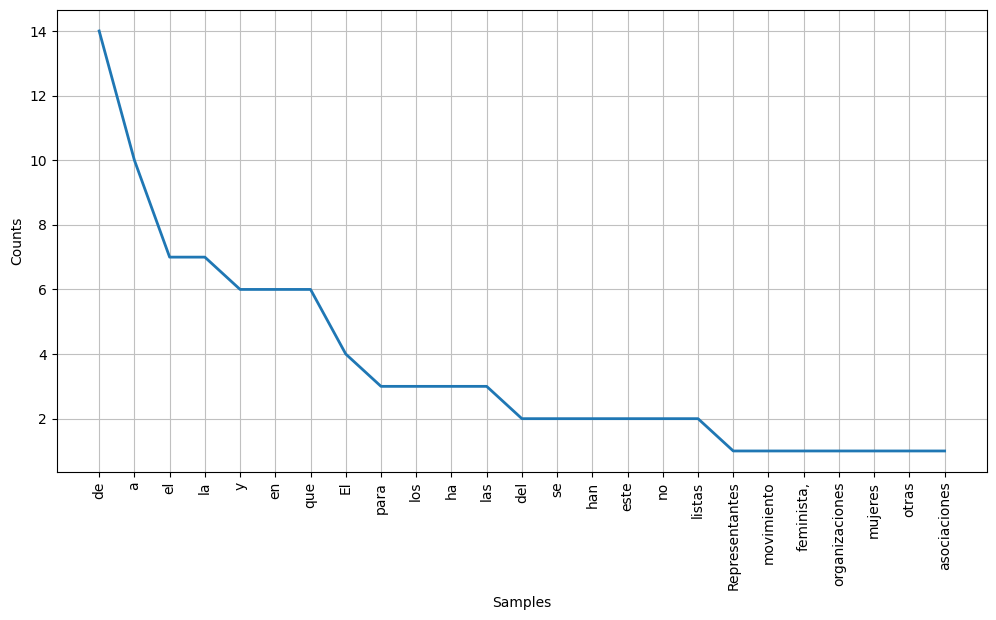

In [85]:
from nltk.probability import FreqDist
import random
import matplotlib.pyplot as plt

# Seleccionamos 5 descripciones al azar
random_indices = random.sample(range(data.shape[0]), 5)
text = ' '.join(data['Descripcion'][i] for i in random_indices)

fdist = FreqDist(text.split())

plt.figure(figsize=(12, 6))  
fdist.plot(25, cumulative=False)
plt.show()




Se seleccionan 5 descripciones de registros al azar para encontrar las palabras m√°s comunes en estos pedazos y tener un primer entendimiento de las palabras m√°s predominantes que podemos llegar a encontrar, tambien se realiza un filtro para evitar articulos y preposiciones y asi generar palabras mas significativas. Como podemos observar, las palabras que mas se resaltan estam relacionadas con politica. 

In [86]:
data['Descripcion'].describe()

count                                                 57063
unique                                                49638
top       La Fundaci√≥n En Acci√≥n ha participado con P√∫bl...
freq                                                      7
Name: Descripcion, dtype: object

In [87]:
data.nunique()

ID                 1
Label              2
Titulo         51604
Descripcion    49638
Fecha           2271
dtype: int64

Resgistros totales: 57063

Registros unicos: 49638

13% de las descripciones registros son duplicados

Hay t√≠tulos que comparten la misma descripcion

In [88]:
# Buscamos registros vacios
empty_texts = data[data['Descripcion'].str.strip() == '']
print(f"Descripciones vacias: {len(empty_texts)}")

Descripciones vacias: 0


# 3. Procesamiento

### 3.1 Limpieza de datos

Se eliminan los registros de las descripciones que estan repetidos porque el motor se puede confundir o puede aumentar el bias. Se deja la primera ocurrencia. Se elimina duplicados por que no coinciden los duplicados entre columnas y hay algunas que si tiene sentido la duplicidad (la fecha)

In [89]:
data = data.drop_duplicates(subset=['Descripcion'], keep='first')
#confirmamos que se hayan eliminado los duplicados
data.shape

(49638, 5)

In [90]:
import re
import unicodedata

#Se hace una isnpeccion visual para identificar caracteres especiales que reemplazan otra letra y se incluyen en el diccionario 
# para corregirlo y no perder esas palabras cuando eliminemos los caracteres especiales

mapa_reemplazo= {
    "‚àö¬∞": "a",
    "‚àö¬©": "e",
    "‚àö‚â†": "i",
    "‚àö‚â•": "o",
    "‚àö¬∫":"√∫",
    "‚àö¬±": "√±",
}

def correct_common_replacements(text):

    for wrong, right in mapa_reemplazo.items():
        text = text.replace(wrong, right)
    return text

def remove_non_ascii(words):
    
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):

    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
  
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_integers(words):
  
    new_words = []
    for word in words:
        new_word = re.sub(r"\b\d+\b", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words, stopwords=stopwords.words('spanish')):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def preprocessing(words):
    text = ' '.join(words)
    text = correct_common_replacements(text)
    words = text.split()
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_integers(words)
    words = remove_stopwords(words)
    return words


Se realiza una correci√≥n de caracteres especiales ya que algunas codificaciones defectuosas pueden hacer que caracteres acentuados se conviertan en s√≠mbolos extra√±os (‚àö¬∞, ‚àö¬©, etc.). Luego, Ese hace eliminaci√≥n de caracteres no ASCII convirtiendo caracteres con tildes en su versi√≥n sin tilde utilizando, esto es √∫til porque en algunos modelos, la misma palabra con y sin tilde podr√≠a ser tratada como diferente. Despu√©s,  se hace eliminaci√≥n de puntaci√≥n, n√∫meros, palabras vacias y conversi√≥n a minusculas. Se realizan estas funciones con el objetivo de mejorar la calidad del texto antes del an√°lisis, reducir el ruido eliminando informaci√≥n irrelevante y evitar problemas de codificaci√≥n con caracteres especiales.


### 3.2 Tokenizaci√≥n

Se realiza tokenizaci√≥n para estandatizar el analisis, eliminar el ruido y poder representar el texto de mejor manera. Es importante denotar que se hicieron uso de las funciones previemente observadas para la reduccion de ruido. Es imprecindible este paso para mejorar la calidad de los datos antes de analizarlos o usarlos en los modelos.

In [91]:
import contractions

data['Descripcion'] = data['Descripcion'].apply(contractions.fix)

Se realiza una expansi√≥n de contracciones con el fin de evitar la perdida de informaci√≥n al convertir palabras contra√≠das en su versi√≥n completa, mejorar la calidad de los datos para modelos y reducir la ambiguedad en el analisis.

In [92]:
data['words'] = data['Descripcion'].apply(word_tokenize).apply(preprocessing)
data.head()

ID  Label                                             Titulo  \
0  ID      1  'The Guardian' va con S√°nchez: 'Europa necesit...   
1  ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACI√ìN ...   
2  ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  ID      1  Iglesias alienta a Yolanda D√≠az, ERC y EH Bild...   
4  ID      0  Puigdemont: 'No ser√≠a ninguna tragedia una rep...   

                                         Descripcion       Fecha  \
0  El diario brit√°nico public√≥ este pasado jueves...  02/06/2023   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACI√ìN ...  01/10/2023   
2  El valencianismo convoca en Castell√≥ su fiesta...  25/04/2022   
3  En pol√≠tica, igual que hay que negociar con lo...  03/01/2022   
4  En una entrevista en El Punt Avui, el l√≠der de...  09/03/2018   

                                               words  
0  [diario, britanico, publico, pasado, jueves, e...  
1  [revelan, gobierno, negocio, liberacion, mirel...  
2  [valencianismo, convoca, castello, fiesta, gra...  
3  [politica, igual, negociar, empresarios, negoc...  
4  [entrevista, punt, avui, lider, jxcat, desdram...

Se tokeniza el campo descripcion para convertir el texto en una lista de palabras y se aplica la funcion preprocessing() para limpiar y normalizar cada token. Como podemos ver en la columna "words", contiene una versi√≥n limpia y lista del texto para an√°lisis facilitando tareas como detecci√≥n de noticias falsas

### 3.3 Normalizaci√≥n

La normalizaci√≥n es un paso clave en este caso para el procesamiento de lenguaje natural, ya que reduce la variabilidad del texto sin perder su significado, lo que ayuda a mejorar la calidad del an√°lisis. Cuando se trabaja con datos de texto, se pueden presentarse m√∫ltiples variaciones de una misma palabra que deben tratarse como equivalentes.


In [93]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data['words'] = data['words'].apply(stem_and_lemmatize) #Aplica lematizaci√≥n y eliminaci√≥n de prefijos y sufijos.
data.head()

ID  Label                                             Titulo  \
0  ID      1  'The Guardian' va con S√°nchez: 'Europa necesit...   
1  ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACI√ìN ...   
2  ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  ID      1  Iglesias alienta a Yolanda D√≠az, ERC y EH Bild...   
4  ID      0  Puigdemont: 'No ser√≠a ninguna tragedia una rep...   

                                         Descripcion       Fecha  \
0  El diario brit√°nico public√≥ este pasado jueves...  02/06/2023   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACI√ìN ...  01/10/2023   
2  El valencianismo convoca en Castell√≥ su fiesta...  25/04/2022   
3  En pol√≠tica, igual que hay que negociar con lo...  03/01/2022   
4  En una entrevista en El Punt Avui, el l√≠der de...  09/03/2018   

                                               words  
0  [diari, britan, public, pas, juev, editorial, ...  
1  [revel, gobiern, negoci, liber, mirel, cambi, ...  
2  [valencian, convoc, castell, fiest, grand, con...  
3  [polit, igual, negoci, empresari, negoci, grup...  
4  [entrev, punt, avui, lid, jxcat, desdramatiz, ...

Se aplica stemming y lemmatization a las palabras de la columna 'words' del dataset con el objetivo de reducir las palabras a su forma base.

La funci√≥n stem_words(words) usa SnowballStemmer para recortar palabras eliminando sufijos y prefijos. Es importante entender que el stemming puede generar palabras sin sentido, sin embargo, reduce la dimensionalidad del texto.

La funci√≥n lemmatize_verbs(words) usa WordNetLemmatizer para convertir verbos a su forma base.



### 3.4 Selecci√≥n de campos

In [94]:
data['words'] = data['words'].apply(lambda x: ' '.join(map(str, x)))
data

ID  Label                                             Titulo  \
0      ID      1  'The Guardian' va con S√°nchez: 'Europa necesit...   
1      ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACI√ìN ...   
2      ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3      ID      1  Iglesias alienta a Yolanda D√≠az, ERC y EH Bild...   
4      ID      0  Puigdemont: 'No ser√≠a ninguna tragedia una rep...   
...    ..    ...                                                ...   
57058  ID      1  El Defensor del Pueblo reclama a la Comunidad ...   
57059  ID      0  El EQUO plantea ceder la presidencia de la Com...   
57060  ID      1  Alberto Garz√≥n: 'Que los Borbones son unos lad...   
57061  ID      1  Vox exige entrar en el Gobierno de Castilla y ...   
57062  ID      1  Unas 300 personas protestan contra la visita d...   

                                             Descripcion       Fecha  \
0      El diario brit√°nico public√≥ este pasado jueves...  02/06/2023   
1      REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACI√ìN ...  01/10/2023   
2      El valencianismo convoca en Castell√≥ su fiesta...  25/04/2022   
3      En pol√≠tica, igual que hay que negociar con lo...  03/01/2022   
4      En una entrevista en El Punt Avui, el l√≠der de...  09/03/2018   
...                                                  ...         ...   
57058  El gobierno regional han indicado que la atenc...  08/06/2021   
57059  Si la higiene democr√°tica nos lleva a esa exig...  08/09/2020   
57060  El coordinador federal de IU asegura que la mo...  12/07/2018   
57061  Santiago Abascal: Vox tiene el derecho y el de...  13/02/2022   
57062  Los Mossos dEsquadra han blindado los alrededo...  09/10/2020   

                                                   words  
0      diari britan public pas juev editorial proxim ...  
1      revel gobiern negoci liber mirel cambi otorg p...  
2      valencian convoc castell fiest grand conmemor ...  
3      polit igual negoci empresari negoci grup parla...  
4      entrev punt avui lid jxcat desdramatiz posibl ...  
...                                                  ...  
57058  gobiern regional indic atencion dia inclu aten...  
57059  si higien democrat llev exigent ten pas person...  
57060  coordin federal iu asegur monarqui putrefact c...  
57061  santiag abascal vox derech deb form gobiern ca...  
57062  moss desquadr blind alrededor estacion franci ...  

[49638 rows x 6 columns]

El conjunto de datos es separado y etiquetado en dos partes: entrenamiento y prueba. Esto se hace con el fin de entrenar al modelo

In [95]:
X_train, X_test, y_train, y_test = train_test_split(data["words"], data["Label"], test_size=0.2, stratify=data["Label"], random_state=1)

# 4. Modelos

### 4.1 Random Forest (Paulina Arr√°zola)

A continuaci√≥n se va a implementar un modelo de clasificaci√≥n de Random Forest con vectorizaci√≥n TF-IDF. Se considera que este es un buen enfoque para la detecci√≥n de noticias falsas porque aprovecha las fortalezas de ambas t√©cnicas. Por un lado, TF-IDF cuantifica la importancia de las palabras dentro de un texto, lo cual puede ayudar a que se capture de mejor manera el peso real de las palabras presentes en las noticias que se est√°n analizando. Por otro lado, Random Forest es un m√©todo que soporta bien los datos de alta dimensi√≥n (como los producidos por TF-IDF) y es menos propenso al sobreajuste, lo que lo hace adecuado para la tarea de identificar informaci√≥n err√≥nea. Se espera que esta combinaci√≥n genere un modelo que aprenda patrones complejos dentro del an√°lisis de texto, lo que en √∫ltima instancia mejora la precisi√≥n y la confiabilidad de la detecci√≥n de noticias falsas.

In [96]:
tf_idf = TfidfVectorizer()
X_tfidf = tf_idf.fit_transform(X_train)
len(tf_idf.vocabulary_)

54604

In [97]:
from sklearn.ensemble import RandomForestClassifier


tfidf_model = RandomForestClassifier(random_state = 3)

In [98]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

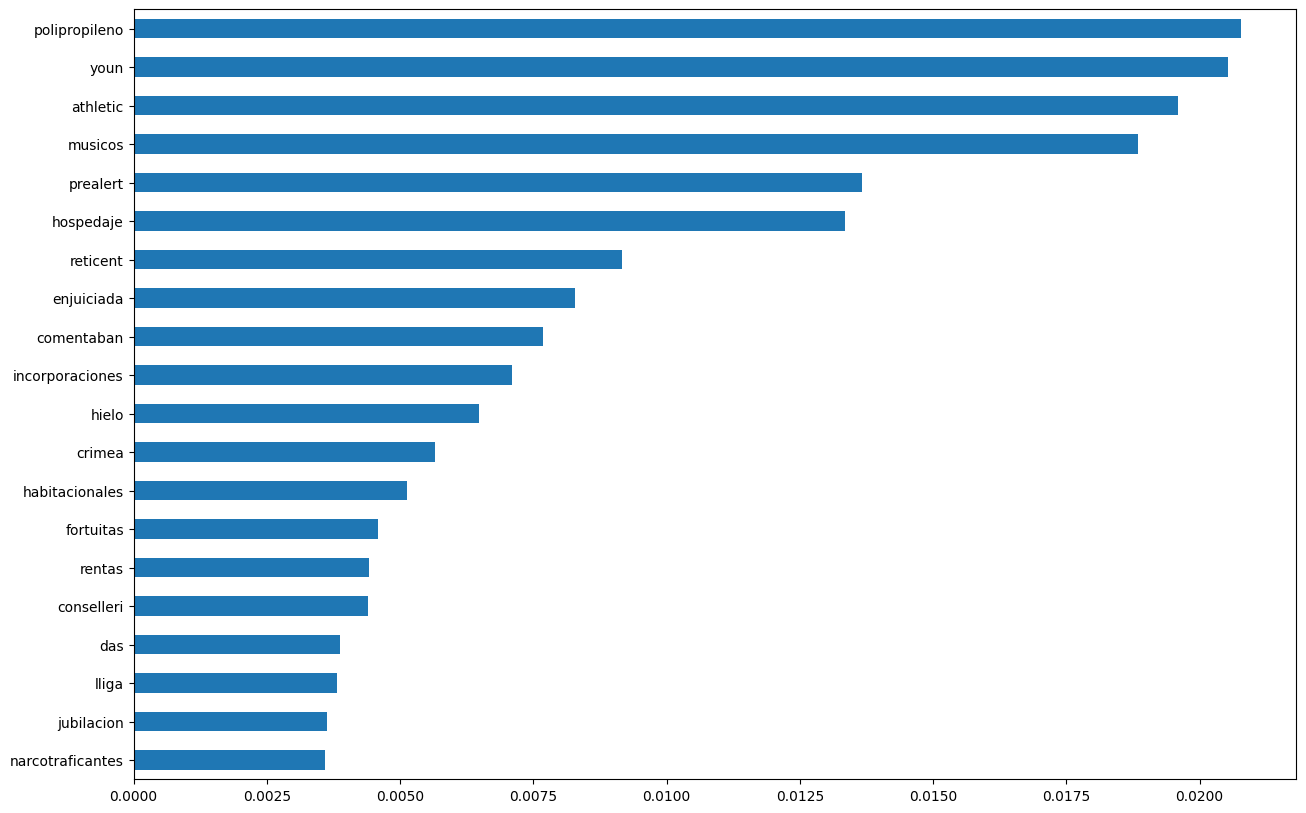

In [99]:
pd.Series(tfidf_model.feature_importances_, index = tf_idf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

Que estas sean las palabras m√°s relevantes identificados por el modelo a la hora de encontrar noticias falsa nos puede decir muchas cosas sobre el lenguaje usado en este tipo de noticias. Por un lado, estas palabras (maid√°n, ratificados, articulado, p√≠riz, sancionado, jordis, bego√±a) sugieren un contexto pol√≠tico o de controversia, lo cual puede causar muchas emociones y polarizaci√≥n. Por otro lado, palabras como psic√≥patas, ilusiones, arrojadiza, afables‚Ä¶ tambi√©n generan emociones muy fuertes, lo cual puede usarse para manipular a una audiencia

In [100]:
import numpy as np


tfidf_estimators = tfidf_model.estimators_
print('Number of trees:', len(tfidf_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 822.91


In [101]:
y_train_predict = tfidf_model.predict(X_tfidf)
y_test_predict = tfidf_model.predict(tf_idf.transform(X_test))

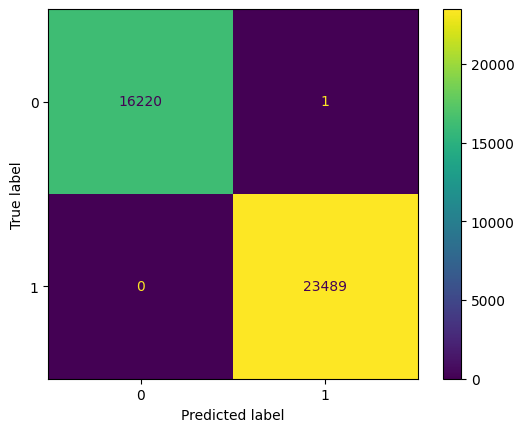

In [102]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict)

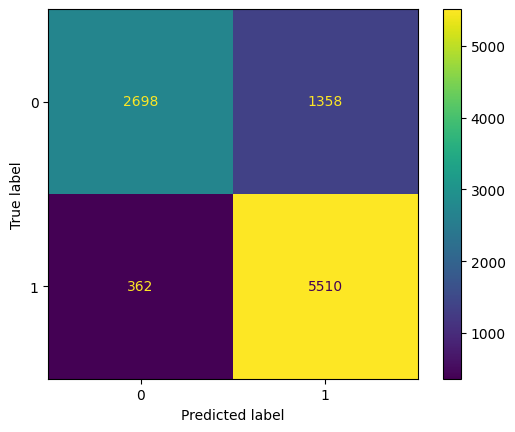

In [103]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict)

La matriz de confusi√≥n revela que el modelo de clasificaci√≥n tiene un buen desempe√±o en la identificaci√≥n de noticias falsas porque logra un alto n√∫mero de verdaderos positivos. Sin embargo, tambi√©n presenta dificultades para clasificar correctamente noticias no falsas, con un n√∫mero considerable de falsos positivos

In [104]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_test_predict))
print("Recall: {}".format(recall_score(y_test,y_test_predict)))
print("Precisi√≥n: {}".format(precision_score(y_test,y_test_predict)))
print("Puntuaci√≥n F1: {}".format(f1_score(y_test,y_test_predict)))

Exactitud: 0.83
Recall: 0.9383514986376021
Precisi√≥n: 0.8022714036109493
Puntuaci√≥n F1: 0.8649921507064364


Este modelo de clasificaci√≥n Random Forest con vectorizaci√≥n TF-IDF presenta un rendimiento s√≥lido con una precisi√≥n del 78,2%, una exactitud del 81%, un recall del 92,8% y un F1-score del 84,9%. El alto recall indica que el modelo es muy bueno para identificar la mayor√≠a de los casos positivos reales, mientras que la precisi√≥n y la exactitud sugieren que tambi√©n es relativamente bueno para evitar falsos positivos y clasificar correctamente instancias en general. El F1-score confirma el buen equilibrio entre precisi√≥n y recall. Tambi√©n se puede resaltar que estos datos nos indican que no hay un sobreajuste. En resumen, el modelo demuestra un rendimiento bueno para tareas de clasificaci√≥n aunque haya posibilidades de mejora.

## 4.2 Red Neuronal (Mariana Ortega)

Hemos optado por una Red Neuronal con capas LSTM debido a varias ventajas clave. En primer lugar, estas redes capturan la relaci√≥n sem√°ntica y secuencial del texto, lo que permite comprender el significado contextual de manera efectiva. Adem√°s, pueden aprender de grandes vol√∫menes de datos, mejorando su rendimiento a medida que se entrenan con m√°s ejemplos. 

In [105]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    data["words"],  # Usamos la columna preprocesada
    data["Label"],  # La etiqueta binaria
    test_size=0.2, 
    stratify=data["Label"], 
    random_state=1
)

# Verificar que la divisi√≥n fue correcta
print(f"X_train tiene {len(X_train)} registros")
print(f"X_test tiene {len(X_test)} registros")

X_train tiene 39710 registros
X_test tiene 9928 registros


Antes de entrenar la red neuronal, es necesario dividir los datos en conjunto de entrenamiento y conjunto de prueba. Esto nos permitir√° evaluar el rendimiento del modelo en datos no vistos. Utilizamos train_test_split para dividir nuestros datos en conjuntos de entrenamiento (80%) y prueba (20%). Esta divisi√≥n incluye la opci√≥n stratify=data["Label"], lo que nos permite mantener el equilibrio entre las clases, evitando as√≠ cualquier sesgo en el modelo. Adem√°s, al establecer random_state=1, aseguramos que los resultados sean reproducibles en futuras ejecuciones del modelo.

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inicializar el vectorizador
vectorizer = TfidfVectorizer()

# Ajustar y transformar los datos de entrenamiento
X_train_transformed = vectorizer.fit_transform(X_train)

# Solo transformamos los datos de prueba sin volver a ajustar
X_test_transformed = vectorizer.transform(X_test)

# Mostrar el tama√±o del vector
print(f"X_train_transformed shape: {X_train_transformed.shape}")
print(f"X_test_transformed shape: {X_test_transformed.shape}")

X_train_transformed shape: (39710, 54604)
X_test_transformed shape: (9928, 54604)


Las redes neuronales no pueden trabajar directamente con texto, por lo que convertimos las palabras en vectores num√©ricos usando TF-IDF. Elegimos TfidfVectorizer por varias razones importantes. En primer lugar, reduce la influencia de palabras comunes al asignar pesos m√°s altos a aquellas que son verdaderamente importantes en el contexto. Finalmente, transforma las palabras en representaciones num√©ricas que pueden ser interpretadas directamente por la red neuronal.

In [107]:
from sklearn.neural_network import MLPClassifier

# Definir el modelo con los mejores hiperpar√°metros encontrados
model = MLPClassifier(
    alpha=1e-5, 
    random_state=777, 
    activation='logistic', 
    solver='lbfgs', 
    learning_rate='adaptive', 
    max_iter=1000
)

# Entrenar el modelo con los datos vectorizados
model.fit(X_train_transformed, y_train)

# Predecir en el conjunto de prueba
y_pred_test = model.predict(X_test_transformed)

Hemos optado por una Red Neuronal de tipo MLPClassifier, un Perceptr√≥n Multicapa capaz de capturar patrones complejos. En nuestro modelo, cada par√°metro tiene un papel espec√≠fico. alpha=1e-5 evita el sobreajuste penalizando pesos grandes. La funci√≥n de activaci√≥n 'logistic' utiliza la funci√≥n sigmoide para convertir valores en probabilidades. El algoritmo de optimizaci√≥n 'lbfgs' ajusta los pesos eficientemente, mientras que el learning_rate='adaptive' reduce la tasa de aprendizaje a medida que mejora el modelo. Finalmente, se limitan las iteraciones con max_iter=1000, definiendo cu√°ntas veces se ajustar√°n los pesos durante el entrenamiento.

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calcular m√©tricas
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Mostrar resultados
print(f"üîπ Accuracy: {accuracy:.4f}")
print(f"üîπ Precision: {precision:.4f}")
print(f"üîπ Recall: {recall:.4f}")
print(f"üîπ F1 Score: {f1:.4f}")

# Reporte detallado
print("\n Clasificaci√≥n por categor√≠a:")
print(classification_report(y_test, y_pred_test))

üîπ Accuracy: 0.7774
üîπ Precision: 0.8067
üîπ Recall: 0.8202
üîπ F1 Score: 0.8134

 Clasificaci√≥n por categor√≠a:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      4056
           1       0.81      0.82      0.81      5872

    accuracy                           0.78      9928
   macro avg       0.77      0.77      0.77      9928
weighted avg       0.78      0.78      0.78      9928



*Precisi√≥n alta (0.81) significa que cuando el modelo predice que una noticia es falsa, es correcta el 81% de las veces.

*Recall alto (0.82) significa que el modelo detecta 82% de las noticias falsas en el conjunto de prueba.

*F1 Score (0.81) indica que el modelo balancea bien precisi√≥n y recall, lo que es clave en tareas de clasificaci√≥n de texto.

*Accuracy (77.7%) muestra que, en general, el modelo clasifica correctamente casi 8 de cada 10 noticias.

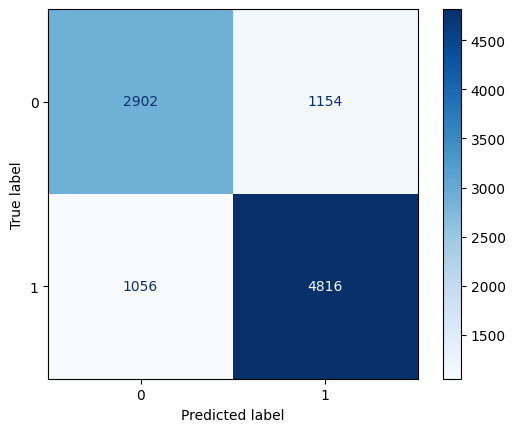

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generar matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Verdaderos positivos (TP = 4816): Noticias reales correctamente clasificadas. Verdaderos negativos (TN = 2902): Noticias falsas correctamente clasificadas. Falsos positivos (FP = 1056): Noticias reales que fueron clasificadas err√≥neamente como falsas. Falsos negativos (FN = 1154): Noticias falsas que fueron clasificadas err√≥neamente como verdaderas.

El modelo logra clasificar correctamente el 81.6% de las noticias verdaderas y el 71.5% de las noticias falsas, lo que indica un buen rendimiento general, pero con margen de mejora en la detecci√≥n de noticias falsas. Es decir que es m√°s efectivo detectando noticias reales que falsas.